In [ ]:
import pandas as pd
import spacy
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from google.colab import files
from sklearn import model_selection
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization,SpatialDropout1D
from tensorflow.keras.metrics import FalsePositives, TruePositives, TrueNegatives, FalseNegatives

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_json('https://raw.githubusercontent.com/triantafillu/Bootcamp-Repository-Language-2/main/data/final_dataset/cmerged_dset.json')
df.head()

,title,url,author,year,text,themes
0,Body and Soul II,https://poets.org/poem/body-and-soul-ii,Charles Wright,2002,(for Coleman Hawkins)\nThe structure of landsc...,[audio & music]
1,Novel,https://poets.org/poem/novel,Arthur Rimbaud,2002,I.\n\nNo one's serious at seventeen.\n—On beau...,"[lust, lgbtq]"
2,Flying,https://poets.org/poem/flying,Sarah Arvio,2002,One said to me tonight or was it day \nor was ...,"[dreams, flight]"
3,Photograph of People Dancing in France,https://poets.org/poem/photograph-people-danci...,Leslie Adrienne Miller,2002,It's true that you don't know them--nor do I \...,[arts & sciences]
4,War Photograph,https://poets.org/poem/war-photograph,Kate Daniels,2002,A naked child is running\nalong the path towar...,"[violence, arts & sciences, war]"


In [ ]:
df.shape
df.isnull().sum(axis = 0)

title     0
url       0
author    0
year      0
text      0
themes    0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
# Combine text and title
df['full_text'] = df.apply(lambda row: row.title + " " + row.text, axis = 1)
df.head()

,title,url,author,year,text,themes,full_text
0,Body and Soul II,https://poets.org/poem/body-and-soul-ii,Charles Wright,2002,(for Coleman Hawkins)\nThe structure of landsc...,[audio & music],Body and Soul II (for Coleman Hawkins)\nThe st...
1,Novel,https://poets.org/poem/novel,Arthur Rimbaud,2002,I.\n\nNo one's serious at seventeen.\n—On beau...,"[lust, lgbtq]",Novel I.\n\nNo one's serious at seventeen.\n—O...
2,Flying,https://poets.org/poem/flying,Sarah Arvio,2002,One said to me tonight or was it day \nor was ...,"[dreams, flight]",Flying One said to me tonight or was it day \n...
3,Photograph of People Dancing in France,https://poets.org/poem/photograph-people-danci...,Leslie Adrienne Miller,2002,It's true that you don't know them--nor do I \...,[arts & sciences],Photograph of People Dancing in France It's tr...
4,War Photograph,https://poets.org/poem/war-photograph,Kate Daniels,2002,A naked child is running\nalong the path towar...,"[violence, arts & sciences, war]",War Photograph A naked child is running\nalong...


In [ ]:
# Drop useless columns
df.drop(['title', 'text', 'url'], axis=1, inplace=True)
df.head()

,author,year,themes,full_text
0,Charles Wright,2002,[audio & music],Body and Soul II (for Coleman Hawkins)\nThe st...
1,Arthur Rimbaud,2002,"[lust, lgbtq]",Novel I.\n\nNo one's serious at seventeen.\n—O...
2,Sarah Arvio,2002,"[dreams, flight]",Flying One said to me tonight or was it day \n...
3,Leslie Adrienne Miller,2002,[arts & sciences],Photograph of People Dancing in France It's tr...
4,Kate Daniels,2002,"[violence, arts & sciences, war]",War Photograph A naked child is running\nalong...


In [ ]:
# Encode author column
labelencoder = LabelEncoder()
df['author'] = labelencoder.fit_transform(df['author'])
df.head()

,author,year,themes,full_text
0,602,2002,[audio & music],Body and Soul II (for Coleman Hawkins)\nThe st...
1,311,2002,"[lust, lgbtq]",Novel I.\n\nNo one's serious at seventeen.\n—O...
2,3478,2002,"[dreams, flight]",Flying One said to me tonight or was it day \n...
3,2361,2002,[arts & sciences],Photograph of People Dancing in France It's tr...
4,2125,2002,"[violence, arts & sciences, war]",War Photograph A naked child is running\nalong...


In [ ]:
# Decontract words 
def full_form(word):
    if word == "nt": word = 'not'
    if word == "re": word = 'be'
    if word == "d": word = 'would'
    if word == "m": word = 'am'
    if word == "s": word = 'be'
    if word == "ve": word = 'have'
    return word

# Preprocess text
def preprocessing(text):
  tokenizer = RegexpTokenizer(r'\w+')
  text = tokenizer.tokenize(text)
  stop_words = set(stopwords.words('english'))
  cleaned_text = []
  for word in text:
    if word not in stop_words:
      cleaned_text.append(word)
  wnl = WordNetLemmatizer()
  text = [wnl.lemmatize(token) for token in cleaned_text]
  text = [full_form(w).lower() for w in text]

  return text
  

In [ ]:
# Apply preprocessing
df['full_text'] = df['full_text'].apply(preprocessing)
df['full_text']

0        [body, soul, ii, coleman, hawkins, the, struct...
1        [novel, i, no, one, serious, seventeen, on, be...
2        [flying, one, said, tonight, day, passage, two...
3        [photograph, people, dancing, france, it, true...
4        [war, photograph, a, naked, child, running, al...
                               ...                        
17069    [you, can, buy, shoes, painting, you, even, bu...
17070    [you, people, people, ask, shoe, the, valley, ...
17071    [you, that, i, loved, you, i, loved, life, lon...
17072    [your, clothes, of, course, empty, shell, with...
17073    [your, luck, is, about, to, change, ominous, i...
Name: full_text, Length: 17074, dtype: object

In [ ]:
# Delete text which are too short
texts_len = df['full_text'].apply(len)
df.drop(df[texts_len<50].index, inplace=True)

In [ ]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(df['full_text'])

# Encode training data sentences into sequences
df['full_text'] = tokenizer.texts_to_sequences(df['full_text'])

df['full_text']

0        [43, 137, 878, 2, 2671, 1168, 4, 2671, 302, 11...
1        [1, 102, 5, 1379, 146, 311, 18, 1550, 3, 728, ...
2        [978, 5, 42, 962, 8, 1604, 70, 14, 254, 224, 1...
3        [1485, 119, 1086, 2538, 14, 313, 13, 1, 13, 1,...
4        [267, 1485, 6, 698, 69, 706, 239, 585, 297, 7,...
                               ...                        
17068    [2, 648, 124, 1388, 197, 293, 310, 19, 424, 24...
17069    [28, 605, 1010, 1005, 28, 55, 1010, 28, 20, 36...
17070    [28, 119, 119, 342, 678, 2, 854, 1, 627, 1067,...
17071    [28, 32, 1, 376, 28, 1, 376, 22, 40, 5, 28, 1,...
17073    [301, 1709, 201, 1215, 16, 373, 2039, 845, 117...
Name: full_text, Length: 14569, dtype: object

In [ ]:
# Get max training sequence length
maxlen = 150 #max([len(x) for x in df['full_text']])

# Pad the training sequences
padded = pad_sequences(df['full_text'], padding='post', truncating='post', maxlen=maxlen)

padded

array([[  43,  137,  878, ...,   44, 1334, 1596],
       [   1,  102,    5, ...,    0,    0,    0],
       [ 978,    5,   42, ...,    0,    0,    0],
       ...,
       [  28,  119,  119, ...,  170, 1229,  492],
       [  28,   32,    1, ...,    0,    0,    0],
       [ 301, 1709,  201, ...,    0,    0,    0]], dtype=int32)

In [ ]:
df['full_text'] = [x for x in padded]

df['full_text']

0        [43, 137, 878, 2, 2671, 1168, 4, 2671, 302, 11...
1        [1, 102, 5, 1379, 146, 311, 18, 1550, 3, 728, ...
2        [978, 5, 42, 962, 8, 1604, 70, 14, 254, 224, 1...
3        [1485, 119, 1086, 2538, 14, 313, 13, 1, 13, 1,...
4        [267, 1485, 6, 698, 69, 706, 239, 585, 297, 7,...
                               ...                        
17068    [2, 648, 124, 1388, 197, 293, 310, 19, 424, 24...
17069    [28, 605, 1010, 1005, 28, 55, 1010, 28, 20, 36...
17070    [28, 119, 119, 342, 678, 2, 854, 1, 627, 1067,...
17071    [28, 32, 1, 376, 28, 1, 376, 22, 40, 5, 28, 1,...
17073    [301, 1709, 201, 1215, 16, 373, 2039, 845, 117...
Name: full_text, Length: 14569, dtype: object

In [ ]:
# Get a list of themes
themes = []
for index, row in df.iterrows():
  for t in row['themes']:
    if t not in themes:
      themes.append(t)
themes

['audio & music',
 'lust',
 'lgbtq',
 'dreams',
 'flight',
 'arts & sciences',
 'violence',
 'war',
 'heartache',
 'earth',
 'christmas',
 'winter',
 'anxiety',
 'food',
 'language',
 'loneliness',
 'city',
 'old age',
 'storms',
 'love',
 'drugs',
 'family',
 'asian/pacific american heritage month',
 'animals',
 'heroes',
 'public domain',
 'anniversary',
 'beginning',
 'ambition',
 'america',
 'for children',
 'gratitude & apologies',
 'history & politics',
 'fourth of july',
 'creation',
 'earth day',
 'patience',
 'memories',
 'pastoral',
 'popular culture',
 'movies',
 'summer',
 'home',
 'identity',
 'enemies',
 "valentine's day",
 'beauty',
 'memorial day',
 'birds',
 'nature',
 'new year',
 'carpe diem',
 'school & learning',
 'friendship',
 'despair',
 'health & illness',
 'plants',
 'moving',
 'autumn',
 'migration',
 'death',
 'desire',
 'doubt',
 'existential',
 'anger',
 'math',
 'youth',
 "women's history month",
 'myth',
 'translation',
 'breakups',
 'night',
 'landscape

In [ ]:
len(themes)

212

In [ ]:
df.shape

(14569, 4)

In [ ]:
# Label the topic column
def label_themes(theme, row):
   if theme in row['themes']:
      return 1
   else: 
     return 0

In [ ]:
# Dict with metrics (will be transformed into df)
d = {
    'theme' : [],
    'accuracy': [],
     'auc': [],
     'val_accuracy': [],
     'val_auc': [] 
}
d['accuracy']

[]

In [ ]:
def model(X,Y):
  X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.1, random_state=37)
  embedding_dim = 8
  max_features = 5001 
  max_len = 150  

  model1 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=max_features,
                          output_dim=embedding_dim,
                          input_length=max_len),
    keras.layers.SpatialDropout1D(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  model1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC'])

  epochs = 10
  history = model1.fit(np.array(X_train), np.array(Y_train),
            batch_size=128,
            validation_data=(np.array(X_test),np.array(Y_test)),
            epochs=epochs)

  m1 = history.history['accuracy'][-1]
  m2 = history.history['auc'][-1]
  m3 = history.history['val_accuracy'][-1]
  m4 = history.history['val_auc'][-1]
  return [m1,m2,m3,m4]

In [ ]:
# Train a model for every theme
for theme in themes:
  tmp_df = df.copy()
  tmp_df['label'] = tmp_df.apply(lambda row: label_themes(theme, row), axis=1)
  X = np.array(tmp_df['full_text'].to_list())
  Y = np.array(tmp_df['label'].to_list())
  metrics = model(X,Y)
  d['theme'].append(theme)
  d['accuracy'].append(metrics[0])
  d['auc'].append(metrics[1])
  d['val_accuracy'].append(metrics[2])
  d['val_auc'].append(metrics[3])
  print(d)
  

Epoch 1/10
103/103 [==============================] - 2s 8ms/step - loss: 0.4607 - accuracy: 0.8937 - auc: 0.4958 - val_loss: 0.3484 - val_accuracy: 0.8895 - val_auc: 0.5673
Epoch 2/10
103/103 [==============================] - 1s 5ms/step - loss: 0.4018 - accuracy: 0.8937 - auc: 0.5187 - val_loss: 0.3421 - val_accuracy: 0.8895 - val_auc: 0.6167
Epoch 3/10
103/103 [==============================] - 1s 5ms/step - loss: 0.3933 - accuracy: 0.8937 - auc: 0.5250 - val_loss: 0.3479 - val_accuracy: 0.8895 - val_auc: 0.6213
Epoch 4/10
103/103 [==============================] - 1s 5ms/step - loss: 0.3662 - accuracy: 0.8937 - auc: 0.5942 - val_loss: 0.3374 - val_accuracy: 0.8895 - val_auc: 0.6355
Epoch 5/10
103/103 [==============================] - 1s 5ms/step - loss: 0.3516 - accuracy: 0.8937 - auc: 0.6322 - val_loss: 0.3379 - val_accuracy: 0.8895 - val_auc: 0.6277
Epoch 6/10
103/103 [==============================] - 1s 6ms/step - loss: 0.3312 - accuracy: 0.8937 - auc: 0.6909 - val_loss: 0.33

In [ ]:
res_df = pd.DataFrame(d)
res_df

,theme,accuracy,auc,val_accuracy,val_auc
0,audio & music,0.893685,0.857261,0.889499,0.605140
1,lust,0.996797,0.640054,0.993823,0.499655
2,lgbtq,0.948139,0.739844,0.954701,0.761654
3,dreams,0.992602,0.680400,0.991764,0.773645
4,flight,0.997865,0.501978,0.997255,0.548434
...,...,...,...,...,...
207,nursery rhymes,0.999237,0.484514,0.999314,0.500000
208,aphorism,0.999695,0.609084,0.998627,0.474227
209,symbolist,0.999085,0.502023,1.000000,0.000000
210,epithalamion,0.999695,0.605537,1.000000,0.000000


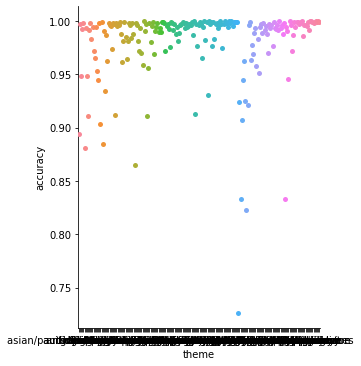

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(x="theme", y="accuracy", data=res_df)
plt.show()

In [ ]:
res_df[res_df['accuracy']<0.80]

,theme,accuracy,auc,val_accuracy,val_auc
140,living,0.725976,0.792842,0.638984,0.546436


In [ ]:
res_df[res_df['val_accuracy']<0.80]

,theme,accuracy,auc,val_accuracy,val_auc
140,living,0.725976,0.792842,0.638984,0.546436
142,relationships,0.833054,0.735892,0.799588,0.631237
147,social commentaries,0.822987,0.838382,0.784489,0.687745


In [ ]:
res_df[res_df['auc']<0.50]

,theme,accuracy,auc,val_accuracy,val_auc
34,creation,0.995500,0.472138,0.995882,0.500000
57,moving,0.999542,0.494112,0.998627,0.500000
89,time,0.995958,0.484530,0.995882,0.613715
116,pacifism,0.998627,0.499164,1.000000,0.000000
131,social justice,0.994051,0.471550,0.991764,0.500000
132,martin luther king jr. day,0.999466,0.474410,0.999314,0.500000
183,blank verse,0.990543,0.480383,0.991764,0.500000
207,nursery rhymes,0.999237,0.484514,0.999314,0.500000


In [ ]:
res_df[res_df['val_auc']<0.50]

,theme,accuracy,auc,val_accuracy,val_auc
1,lust,0.996797,0.640054,0.993823,0.499655
27,beginning,0.995882,0.544923,0.993823,0.480318
30,for children,0.998093,0.602213,0.997941,0.498281
50,new year,0.998170,0.653913,0.997941,0.498968
59,migration,0.996644,0.624904,0.995196,0.480345
69,translation,0.997636,0.602670,0.997941,0.497593
73,luck,0.999237,0.525599,0.999314,0.378434
75,for teens,0.997788,0.630467,0.994509,0.498620
86,past,0.994661,0.723980,0.995882,0.496210
90,father's day,0.997102,0.682601,0.996568,0.493802


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
res_df.to_csv('/drive/My Drive/Colab Notebooks/metrics.csv')

In [ ]:
# THemes to drop
to_drop = []
l1 = res_df[res_df['val_accuracy']<0.80]['theme'].unique()
l2 = res_df[res_df['val_accuracy']<0.80]['theme'].unique()
l3 = res_df[res_df['auc']<0.50]['theme'].unique()
l4 = res_df[res_df['val_auc']<0.50]['theme'].unique()
l = [*l1, *l2, *l3, *l4]
to_drop = list(set(l))
to_drop

['prose poem',
 'luck',
 "father's day",
 'september 11',
 'travel',
 'epithalamion',
 'philosophy',
 'nursery rhymes',
 'silence',
 'creation',
 'chanukah',
 'technology',
 'villanelle',
 'social commentaries',
 'turmoil',
 'for teens',
 'relationships',
 'terza rima',
 'farewell',
 'imagist',
 'past',
 'slavery',
 'aphorism',
 'martin luther king jr. day',
 'pacifism',
 'symbolist',
 'epistle',
 'blank verse',
 'for children',
 'vanity',
 'nostalgia',
 'sex',
 'survival',
 'alliteration',
 'migration',
 'social justice',
 'visual poetry',
 'infidelity',
 'moving',
 'haiku',
 'time',
 'living',
 'lust',
 'translation',
 'beginning',
 'new year']